#### Notebook to split FOUNDIN-PD SCRN quants by celltype
will also output a scaled and covariate adjusted file for full dataset; ie across defined cell-types

In [1]:
!date

Wed Aug  4 22:23:40 UTC 2021


#### do imports and set notebooks variables

In [2]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import concurrent.futures
import random
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from umap import UMAP
import ppscore as pps
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
# naming
cohort = 'foundin'
quant_type = 'scrn'
day = 'da65'

# directories
wrk_dir = f'/home/jupyter/sceqtl'
quants_dir = f'{wrk_dir}/quants'
info_dir = f'{wrk_dir}/sample_info'

# in files
quants_local_file = f'{quants_dir}/{quant_type}.avgnormbroad.csv'
features_file = f'{quants_dir}/gencode_v29.lncipedia_v5_2_hc.annotation.pkl'
covariates_file = f'{info_dir}/{cohort}_{quant_type}_sample_info.csv'
# gene file of genes to exclude from variance detection
# using Human Protein Atlas 'elevated' gene set for braim
tissue_genes_file = f'{quants_dir}/tissue_category_rna_brain_Tissue.tsv'

# out files
feature_ids_exclude_var_file = f'{quants_dir}/{cohort}.{quant_type}.variance.features.exclude.txt'
all_quants_file = f'{quants_dir}/{cohort}.{quant_type}.hdf5'
umap_covs_file = f'{info_dir}/{cohort}.{quant_type}.umap.covs.csv'
scaled_file = f'{quants_dir}/{cohort}.{quant_type}.scaled.hd5f'
adj_quants_file = f'{quants_dir}/{cohort}.{quant_type}.scaled.adj.hdf5'

# constants
max_missing_rate = 0.25
min_ppscore = 0.05
min_pearson = 0.22

other_id_columns = ['sampleid', 'cdi', 'PPMI_ID', 'DZNE_Barcode', 'DZNE_ID', 
                    'participant_id', 'wgsid', 'PATNO', 'Barcode_LNG', 
                    'Barcode_DZNE', 'Alternate MRN', 'IID', 'FID']
# to match geno's use PPMI3966 Batch3
replace_id_dict = {'PPMI3966B3': 'PPMI3966'}

cell_abbrvs = {'Immature Dopaminergic Neurons': 'iDA', 
              'Dopaminergic Neurons': 'DA', 
              'Proliferating Floor Plate Progenitors': 'PFPP', 
              'Early neuron Progenitor': 'eNP', 
              'Ependymal-like Cells': 'ElC', 
              'Late neuron Progenitor': 'lNP', 
              'Neuroepithelial-like Cells': 'NlC'}

### notebook functions

#### functions for detection rates calculations and plotting

In [4]:
def calculate_detection_rates(this_df, quant_type, round_percision=1, 
                              min_quant_value=None):
    if min_quant_value is None:
        min_quant_value = this_df.round(round_percision).min().min()

    print(f'minimun {quant_type} value is {min_quant_value}')

    detected_df = this_df.mask(this_df.round(round_percision) <= min_quant_value, 0)

    # calculate the missing counts from the detected df mask
    trait_missing_rates = round(detected_df.isin({0}).sum(0)/detected_df.shape[0], 2)
    sample_missing_rates = round(detected_df.isin({0}).sum(1)/detected_df.shape[1], 2)

    print(f'{len(trait_missing_rates)} features with mean missing \
rate = {trait_missing_rates.mean()}')
    print(f'{len(sample_missing_rates)} samples with mean missing \
rate = {sample_missing_rates.mean()}')
    return trait_missing_rates, sample_missing_rates

def plot_missing_rates(feature_rates, sample_rates):
    sns.set()
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    sns.distplot(feature_rates.values)
    plt.title('Features missingness rates')
    plt.subplot(2, 2, 2)
    sns.distplot(sample_rates.values)
    plt.title('Samples missingness rates')
    plt.show()
    
def bad_callrate_features(features_missing_rates, max_missing_rate):
    bad_call_rates = features_missing_rates[features_missing_rates > max_missing_rate]
    print(f'features with bad call rates shape {bad_call_rates.shape}, \
fraction of features with bad rates {bad_call_rates.shape[0]/features_missing_rates.shape[0]}')
    return bad_call_rates

def subset_well_detected_features(this_df, bad_call_rates):
    detected_traits = list(set(this_df.columns)-set(bad_call_rates.index))
    this_wd_df = this_df[detected_traits]
    print(f'shape of well detected quants {this_wd_df.shape}')
    return this_wd_df

#### function to generate and visualize known and unknow covariates using UMAP and PPScore

In [5]:
# function for plotting umap of traits with covar high lights
def plot_umap_clusters(umap_df, hue_cov=None, style_cov=None, size_cov=None):
    # umap_plot_file = f'{WRKDIR}/{COHORTBUILD}.umap.residuals.umap.plot.png'
    sns.set()
    plt.figure(figsize=(12, 12))
    sns_plot = sns.scatterplot(x='x_umap',y='y_umap', \
                               hue=hue_cov, style=style_cov, size=size_cov, \
                               data=umap_df)
    plt.xlabel('x-umap')
    plt.ylabel('y-umap')
    #plt.legend(loc='lower right', prop={'size': 6})
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size': 10})
    # plt.savefig(umap_plot_file,format='png',dpi=600,bbox_inches='tight')
    plt.show()

# small function to generate umap from pandas dataframe, for all features (columns) \
# and return back as dataframe with source index intact
def generate_umap_covs_df(this_df, other_covs_df=None, 
                             rnd_digits=3, merge_input=False):
    #run UMAP on the data frame features
    umap_results = UMAP(random_state=42).fit_transform(this_df)
    umap_df = pd.DataFrame(umap_results,columns=['x_umap','y_umap'], \
                                       index=this_df.index).round(rnd_digits)
    if merge_input:
        umap_df = umap_df.merge(this_df,left_index=True,right_index=True)
    if other_covs_df is not None:
        umap_df = umap_df.merge(other_covs_df, how='left', 
                                left_index=True, right_index=True)
    print(f'The dimensions of the umap df and the traits are {umap_df.shape}')
    return umap_df 

# function to iterate over target features and use PPScore to find covarites of interest
def pps_predict_targets(this_df, target_list):
    covs_to_check = []
#     covs_list = ['x_umap', 'y_umap']
    for this_cov in target_list:
        print(this_cov)
        predictors_df = pps.predictors(this_df, this_cov)
        # drop anything that has ppscore of zero
        predictors_df = predictors_df.loc[predictors_df['ppscore'] > min_ppscore]
        display(predictors_df)
        covs_to_check.extend(list(predictors_df['x'].values))

    print(f'found {len(covs_to_check)} covariates that may preditct target covariates')    
    return covs_to_check

# plot ppscore matrix 
def plot_ppscore_matrix(this_df, covs_to_check, cov_targets):
    matrix_df = pps.matrix(this_df[(set(covs_to_check) | set(cov_targets))])
    matrix_df = matrix_df.loc[matrix_df['ppscore'] > min_ppscore]
    print(matrix_df.shape)

    matrix_df['ppscore'] = matrix_df['ppscore'].round(2)
    plot_matrix_df = matrix_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    print(plot_matrix_df.shape)
    # display(plot_matrix_df)

    plt.figure(figsize=(plot_matrix_df.shape[0],plot_matrix_df.shape[1])) 
    sns.heatmap(plot_matrix_df, vmin=0, vmax=1, cmap='Blues', linewidths=0.05, 
                annot=True, annot_kws={'fontsize':12})
    plt.title('PPScore heatmap')
    plt.show()
    
# plot heatmap of Pearson correlation matrix for PPScore covariates
def plot_correlation_heatmap(this_df, covs_list : list=None):
    sns.set()
    cor = this_df.corr(method='pearson')
    cor.dropna(how='all', inplace=True)
    modified_title = ''
    if covs_list is not None:
        
        limited_cor = cor[covs_list]
        cor = limited_cor.loc[(limited_cor['x_umap'].abs() > min_pearson) | 
                              (limited_cor['y_umap'].abs() > min_pearson)]
        modified_title = 'limited'
    print(cor.shape)
    fig_width = cor.shape[1] if cor.shape[1] > 12 else 12
    fig_height = cor.shape[0] if cor.shape[1] > 12 else 12
    plt.figure(figsize=(fig_width, fig_height))        
    sns.heatmap(cor[(cor > min_pearson) | (cor < -min_pearson)], annot=True, 
                annot_kws={"fontsize":10}, linewidths=0.05, cmap='Blues')    
    plt.title(f'Pearson heatmap of PPScore covariates {modified_title}')
    plt.show()

# function to one-hot encode the categorical covariates and merge with continuous ones    
def dummy_covs_as_needed(this_df):
    temp_df = this_df.copy()
    cats_df = temp_df.select_dtypes(include=['object'])
    print(f'categoricals shape {cats_df.shape}')
    dums_df = pd.get_dummies(cats_df)
    print(f'one-hot encoded categoricals shape {dums_df.shape}')

    temp_df = temp_df.merge(dums_df, how='inner', left_index=True, right_index=True)
    print(f'new covs df shape {temp_df.shape}')
    return temp_df    

#### visualization functions

In [6]:
# small function to plot before and after of transform based on named feature,
# or if a feature isn't specified then one pull at random
def plot_trnsfrm_effect_example(before_df, after_df, feature_id=None,
                                bf_label='quantile transformed', 
                                af_label='quantile transformed and covariate adjusted'):
    # if no feature ID provided get randome one
    if feature_id is None:
        feature_id = random.sample(list(after_df.columns), 1)[0]
    
    sns.distplot(before_df[feature_id])
    plt.title(f'{feature_id} {bf_label}')
    plt.show()
    sns.distplot(after_df[feature_id])
    plt.title(f'{feature_id} {af_label}')
    plt.show()
    sns.scatterplot(x=before_df[feature_id], y=after_df[feature_id])
    plt.title(f'{feature_id}')
    plt.xlabel(f'{bf_label}')
    plt.ylabel(f'{af_label}')

#### analysis functions

In [7]:
# small function to perform the quantile transform and minmax scale on a pandas dataframe
def scale_dataframe(this_df : pd.DataFrame):
    scaledX = MinMaxScaler().fit_transform(QuantileTransformer(output_distribution='normal')
                                           .fit_transform(this_df))
    scaled_df = pd.DataFrame(data=scaledX, columns=this_df.columns, 
                                 index=this_df.index)  
    return scaled_df    

# exclude low variance features from covariate generation
def exclude_low_var_features(this_df: pd.DataFrame, quartile_to_drop: str ='25%', 
                             known_feature_to_drop=None):
    quants_vars = this_df.var() 
    print(quants_vars.describe())
    # drop features within the lower quartile of variance
    min_variance = quants_vars.describe()['25%']
    # min_variance = quants_vars.describe()['50%']
    keep = quants_vars[quants_vars > min_variance]
    if known_feature_to_drop is not None:
        keep_ids = set(keep.index) - set(known_feature_to_drop)
    else:
        keep_ids = set(keep.index)
    quants_wd_var_df = this_df[keep_ids]
    print(f'shape of the features to keep {keep.shape}')
    print(f'shape of input features df {this_df.shape}')
    print(f'shape of variance features df {quants_wd_var_df.shape}')
    return quants_wd_var_df

# function to fit linear model to covariates and calculate the standardized residuals
def covariate_residuals(traits_df, covars_df):
    lm = LinearRegression(n_jobs=16)
    residuals_df = traits_df.copy()
    covar_scores_by_trait = {}

    for trait in traits_df:
            model = lm.fit(covars_df, traits_df[trait])
            covar_scores_by_trait[trait] = model.score(covars_df,traits_df[trait])
            model_predicted = model.predict(covars_df)
            residuals_df[trait] = stats.zscore(traits_df[trait] - model_predicted)
            
#     # We can use a with statement to ensure threads are cleaned up promptly
#     with concurrent.futures.ProcessPoolExecutor() as ppe:
#         # Start the load operations and mark each future with its URL
#         future_to_residual = {executor.submit(compute_residuals, trait): trait for trait in traits_df}
#         for future in concurrent.futures.as_completed(future_to_residual):
#             covar_scores_by_trait[trait], residuals_df[trait] = future_to_residual[future]

    # scale the residuals
    residualsX = MinMaxScaler().fit_transform(residuals_df)
    residuals_df = pd.DataFrame(data=residualsX, columns=traits_df.columns, 
                                index=traits_df.index)
    
    # grab the covariates model scores
    covar_scores_by_trait_df = pd.DataFrame.from_dict(covar_scores_by_trait,
                                                      columns=['score'],
                                                      orient='index').round(3)
    covar_scores_by_trait_df.index.name = 'featureID'
    return residuals_df, covar_scores_by_trait_df


#### input output functions

In [8]:
# small function to save hdf file
def write_df_to_hdf(this_df, file_name, key='quants', mode='w'):
    this_df.to_hdf(file_name, key=key, mode=mode)

#### load the quantified features matrix

In [ ]:
%%time
quant_dd = dd.read_csv(quants_local_file, sep='\t')
print(quant_dd.shape)

quant_df = quant_dd.compute().transpose()
print(quant_df.shape)
# add the index name
quant_df.index.name = 'assayid'

# now save the transposed quant matrix in faster file type
quant_df.to_hdf(all_quants_file, key='quants', mode='w')
# display(quant_df.head())

#### split name index to find info

In [ ]:
id_parts = quant_df.index.str.split(':', expand=True).to_frame()
id_parts.columns = ['assayid', 'cell_type']
# id_parts['cell_type'] = id_parts['cell_type'].str.replace(' ','')
id2_parts = id_parts['assayid'].str.split('_', expand=True)
id2_parts.columns = ['assay', 'sampleid', 'cdi', 'day']
id_parts['fullassayid'] = quant_df.index
id_parts['assay'] = id2_parts['assay']
id_parts['sampleid'] = id2_parts['sampleid']
id_parts['cdi'] = id2_parts['cdi']
id_parts['day'] = id2_parts['day']
print(id_parts.shape)
# display(id_parts.head())

#### what are the cell type counts and day counts (should only be day 65)

In [11]:
print(id_parts['cell_type'].value_counts())
print(id_parts['day'].value_counts())

Immature Dopaminergic Neurons            83
Dopaminergic Neurons                     83
Proliferating Floor Plate Progenitors    83
Early neuron Progenitor                  83
Ependymal-like Cells                     83
Late neuron Progenitor                   83
Neuroepithelial-like Cells               83
Name: cell_type, dtype: int64
da65    581
Name: day, dtype: int64


#### capture the assayid to wgsid for formatting phenotypes for use with wgs genotypes later

In [12]:
id_map = id_parts[['sampleid', 'assayid']]
id_map['sampleid'].replace(replace_id_dict, inplace=True)

#### load covariates files

In [ ]:
covs_df = pd.read_csv(covariates_file, index_col=0)
# drop any duplicated indices
print(covs_df.shape)
covs_df = covs_df[~covs_df.index.duplicated(keep='first')]
print(covs_df.shape)
# display(covs_df.sample(5))

In [14]:
# check for any unexpected samples; ie probably name frmt issue
set(id_parts['sampleid']) - set(covs_df['PPMI_ID'])

{'PPMI3966B3', 'PPMI3966E6', 'PPMI3966E8'}

#### for merging known covariates with umaps will need to add cell labelled assay ids into covariates dataframe

In [ ]:
id_parts.reset_index(inplace=True)
id_parts.drop(columns=['level_0', 'level_1'], inplace=True)
covs_df = covs_df.merge(id_parts, left_on='PPMI_ID', right_on='sampleid')
covs_df.index = covs_df['fullassayid']
covs_df = covs_df[~covs_df.index.duplicated(keep='first')]
print(covs_df.shape)
# display(covs_df.head())

#### for further analysis remove the ID columns

In [17]:
print(covs_df.shape)
cols_to_keep = set(covs_df.columns) - set(other_id_columns)
covs_df = covs_df[cols_to_keep]
print(covs_df.shape)
# display(covs_df.head())

(560, 88)
(560, 75)


#### load feature annotations

In [18]:
%%time
features_df = pd.read_pickle(features_file)
print(features_df.shape)
display(features_df.head())

(3072652, 50)


,seqname,source,feature,start,end,score,strand,frame,ID,ccdsid,...,transcript_alias_4,transcript_alias_5,transcript_alias_6,transcript_alias_7,transcript_alias_8,transcript_alias_9,transcript_id,transcript_name,transcript_support_level,transcript_type
0,chr10,ENSEMBL,CDS,100275465,100275493,.,-,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000614731.4,BLOC1S2-205,2,protein_coding
1,chr10,ENSEMBL,CDS,100275465,100275493,.,-,2,NaN,CCDS73179.1,...,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000618916.4,BLOC1S2-206,5,protein_coding
2,chr10,ENSEMBL,CDS,100280124,100280228,.,-,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000614731.4,BLOC1S2-205,2,protein_coding
3,chr10,ENSEMBL,CDS,100280124,100280228,.,-,2,NaN,CCDS73179.1,...,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000618916.4,BLOC1S2-206,5,protein_coding
4,chr10,ENSEMBL,CDS,100280934,100281053,.,-,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000614731.4,BLOC1S2-205,2,protein_coding


CPU times: user 2min 52s, sys: 3.86 s, total: 2min 55s
Wall time: 2min 55s


#### since single-cell features are typically gene names instead of geneIDs see if missing from feature annots

In [19]:
genes_missing_in_annots = set(quant_df.columns) - set(features_df['gene_name'])
if len(genes_missing_in_annots) < 20:
    print(len(genes_missing_in_annots))
    print(genes_missing_in_annots)
else:
    print(len(genes_missing_in_annots))
    print(list(genes_missing_in_annots)[:20])

162
['MIR100HG.1', 'RF00017.81', 'SPATA41.1', 'TBCE.1', 'GATA6-AS1.1', 'RF00019.680', 'HYMAI.1', 'RF00017.28', 'RAD51-AS1.1', 'DNM3OS.1', 'RF00554.8', 'LGALSL-DT.1', 'RF01241.1', 'FIRRE.1', 'LINC01517.1', 'ATXN7.1', 'RF00017.146', 'RF00003.9', 'CSTF3-DT.1', 'MKLN1-AS.1']


#### find IDs for features on sex chromosomes, for dropping later

In [20]:
sex_chr_feature_ids = features_df.loc[features_df['seqname']
                                      .isin(['chrX', 'chrY'])]['gene_name'].unique()
print(len(sex_chr_feature_ids))

4389


#### get counts by cell-type

In [21]:
cell_types = id_parts['cell_type'].value_counts()
for cell_type, count in cell_types.items():
    print(f'{cell_type} {count}')

Immature Dopaminergic Neurons 83
Dopaminergic Neurons 83
Proliferating Floor Plate Progenitors 83
Early neuron Progenitor 83
Ependymal-like Cells 83
Late neuron Progenitor 83
Neuroepithelial-like Cells 83


#### save the quantified features matrix split by cell-type

In [22]:
%%time
# run the saves in parallel    
with concurrent.futures.ThreadPoolExecutor() as tpe:
    for cell_long in cell_types.index:
        # get cell type abbreviation
        cell_short = cell_abbrvs.get(cell_long)
        # get id info for samples of this cell type
        cell_df = id_parts.loc[id_parts['cell_type'] == cell_long]
        # get quantified features for samples of this cell type
        this_quant_df = quant_df[quant_df.index.isin(cell_df['fullassayid'])]
        # since all quants for one cell type drop cell name portion from sample
        this_quant_df.index = this_quant_df.index.str.replace(f':{cell_long}', '')
        print(f'{cohort} {cell_short} {this_quant_df.shape}')
        # now save these cell type quantified features
        cohort_quant_filename = f'{quants_dir}/{cohort}.{day}.{cell_short}.{quant_type}.hdf5'
        tpe.submit(write_df_to_hdf, this_quant_df, cohort_quant_filename)    

foundin iDA (83, 34960)
foundin DA (83, 34960)
foundin PFPP (83, 34960)
foundin eNP (83, 34960)
foundin ElC (83, 34960)
foundin lNP (83, 34960)
foundin NlC (83, 34960)
CPU times: user 328 ms, sys: 211 ms, total: 539 ms
Wall time: 1.31 s


#### scale the full dataset using quantile transform and minmax scaler

In [29]:
%%time
traits_scaled_df = scale_dataframe(quant_df)

CPU times: user 39.2 s, sys: 128 ms, total: 39.3 s
Wall time: 39.3 s


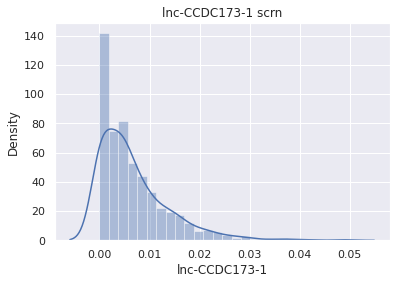

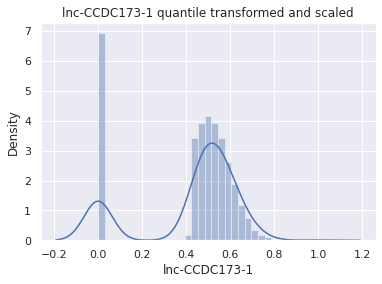

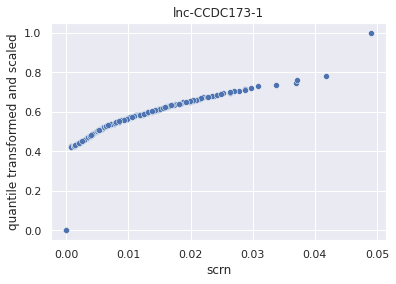

In [30]:
plot_trnsfrm_effect_example(quant_df, traits_scaled_df,
                            bf_label=quant_type, 
                            af_label='quantile transformed and scaled')

### generate covariates for variance

#### calculate, plot detection rates and subset well detected features

minimun scrn value is 0.0
34960 features with mean missing rate = 0.6757500000000057
581 samples with mean missing rate = 0.6756454388984526


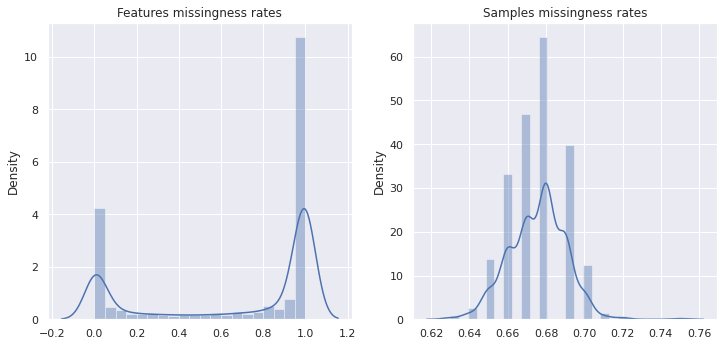

features with bad call rates shape (25349,), fraction of features with bad rates 0.7250858123569794
shape of well detected quants (581, 9611)
CPU times: user 14.2 s, sys: 180 ms, total: 14.4 s
Wall time: 11.4 s


In [31]:
%%time
trait_miss_rates, sample_miss_rates = calculate_detection_rates(quant_df, quant_type)
plot_missing_rates(trait_miss_rates, sample_miss_rates)
bad_call_rate_features = bad_callrate_features(trait_miss_rates, max_missing_rate)
traits_scaled_df = subset_well_detected_features(traits_scaled_df, bad_call_rate_features)

#### save scaled, well detected data for all days

In [32]:
write_df_to_hdf(traits_scaled_df, scaled_file)

#### take a look at variance in data, assuming mostly driven by cell-type

#### exclude low variance features from covariate generation

In [33]:
quants_var_df = exclude_low_var_features(traits_scaled_df)

count    9611.000000
mean        0.010103
std         0.000535
min         0.009920
25%         0.009920
50%         0.009920
75%         0.009920
max         0.019860
dtype: float64
shape of the features to keep (7021,)
shape of input features df (581, 9611)
shape of variance features df (581, 7021)


### take a look at the data

#### generate unknown covariates and see if know covariates are source of variations

The dimensions of the umap df and the traits are (581, 77)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,cell_type,x_umap,0.822214,regression,True,mean absolute error,4.463530,0.793555,DecisionTreeRegressor()
1,y_umap,x_umap,0.424357,regression,True,mean absolute error,4.456465,2.565334,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,cell_type,y_umap,0.535026,regression,True,mean absolute error,1.587423,0.738110,DecisionTreeRegressor()
1,x_umap,y_umap,0.233860,regression,True,mean absolute error,1.584642,1.214058,DecisionTreeRegressor()


found 4 covariates that may preditct target covariates
(9, 9)
(3, 3)


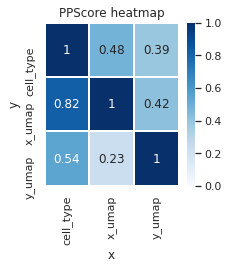

categoricals shape (581, 1)
one-hot encoded categoricals shape (581, 7)
new covs df shape (581, 10)
(9, 9)


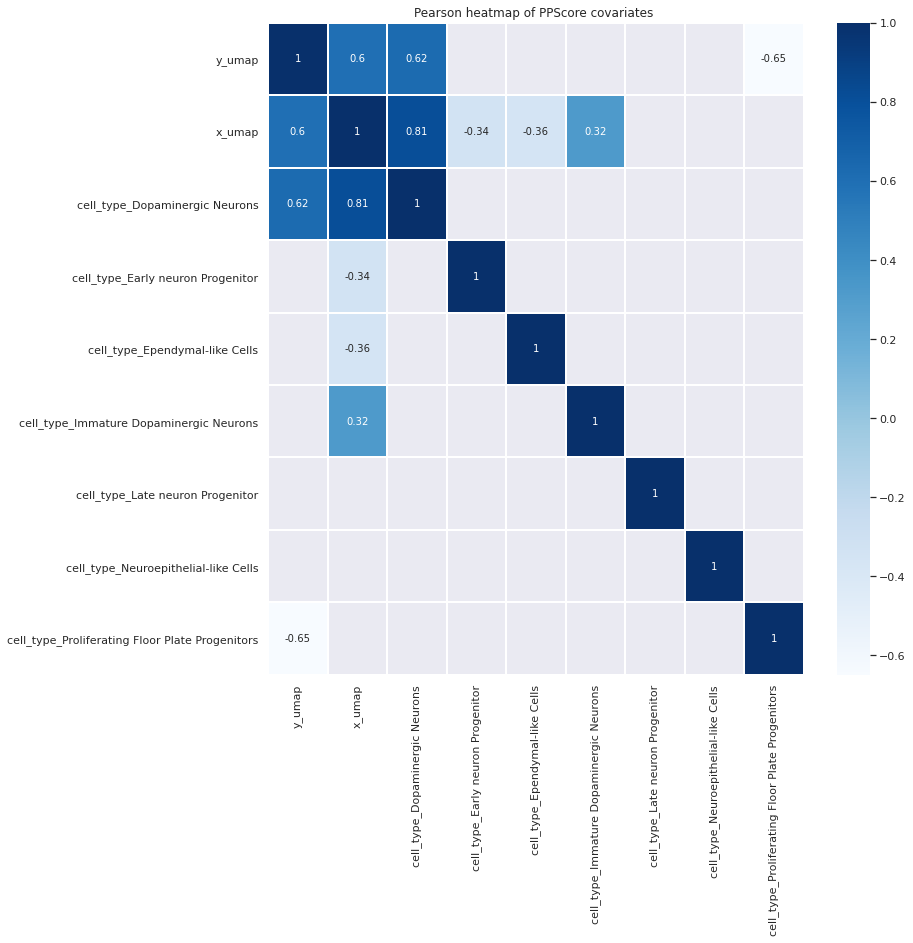

(7, 2)


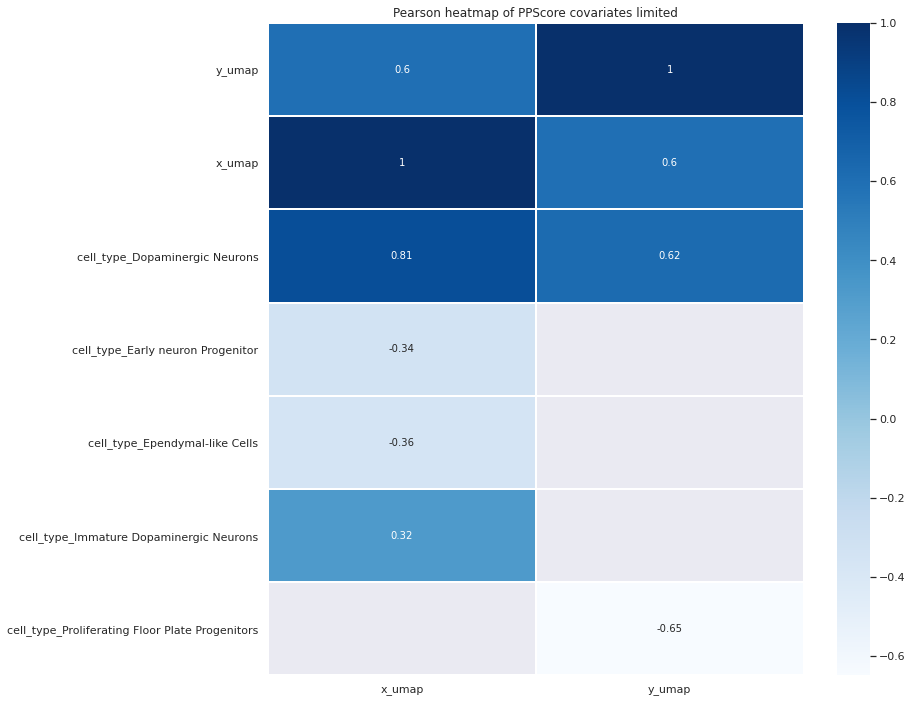

CPU times: user 11.1 s, sys: 174 ms, total: 11.3 s
Wall time: 5.07 s


In [34]:
%%time
umap_df = generate_umap_covs_df(quants_var_df, covs_df)
covs_target_list = ['x_umap', 'y_umap']
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

#### plot umap of with known covariates of interest

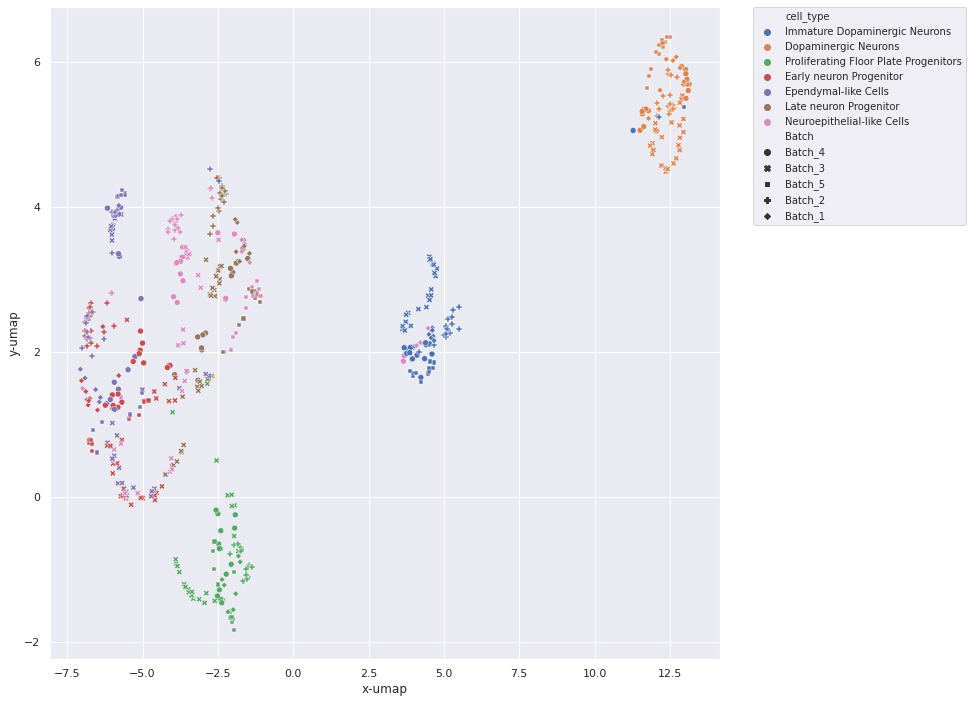

In [36]:
plot_umap_clusters(umap_df, hue_cov='cell_type', style_cov='Batch')

#### do quick anova by day to identify features change with cell differentiation 

this is since we know differention should be largest source of variation, so figure out which features to exclude to get around

In [37]:
# split samples by group (day)
feats_by_cell = {}
for cell_long in cell_types.index:
    # get cell type abbreviation
    cell_short = cell_abbrvs.get(cell_long)
    # get id info for samples of this cell type
    cell_df = id_parts.loc[id_parts['cell_type'] == cell_long]
    # get quantified features for samples of this cell type
    this_quant_df = traits_scaled_df[traits_scaled_df.index.isin(cell_df['fullassayid'])]
    feats_by_cell[cell_short] = this_quant_df
    print(f'{cohort} {cell_short} {this_quant_df.shape}')

# calculate one-way ANOVA for the groups
fvalues, pvalues = stats.f_oneway(feats_by_cell.get('iDA'), 
                                  feats_by_cell.get('DA'), 
                                  feats_by_cell.get('PFPP'), 
                                  feats_by_cell.get('eNP'), 
                                  feats_by_cell.get('ElC'), 
                                  feats_by_cell.get('lNP'), 
                                  feats_by_cell.get('NlC'))

# make df from results
anova_results_df = pd.DataFrame(data={'fvalues': fvalues, 'pvalues': pvalues}, 
                                index=traits_scaled_df.columns)
# apply a B&H FDR to pvalues
anova_results_df['bh_fdr'] = smm.fdrcorrection(pvalues)[1]

print(anova_results_df.shape)
display(anova_results_df.head())

foundin iDA (83, 9611)
foundin DA (83, 9611)
foundin PFPP (83, 9611)
foundin eNP (83, 9611)
foundin ElC (83, 9611)
foundin lNP (83, 9611)
foundin NlC (83, 9611)
(9611, 3)


,fvalues,pvalues,bh_fdr
RNMT,69.391984,7.706814e-65,1.882821e-64
DNAJC2,16.203249,2.860373e-17,3.150114e-17
ING1,31.797078,4.515055e-33,6.077618e-33
PHYKPL,30.629313,5.993558e-32,7.945391e-32
MTRF1L,36.854399,7.907322e-38,1.153396e-37


In [38]:
anova_results_df.loc[anova_results_df['bh_fdr'] < 0.05].shape

(9602, 3)

#### determine final set of features to use for variance detection
exluding bottom 25% variance features, sex features, tissue elevated features 

cannot use the cell difference genes from anova as that is pretty much all of them

In [30]:
no_change_features = anova_results_df.loc[anova_results_df['bh_fdr'] > 0.05].index.values
print(len(no_change_features))

no_change_variance_features = (set(no_change_features) & set(quants_var_df.columns)) - set(sex_chr_feature_ids)
print(len(no_change_variance_features))

5446
3753


In [40]:
tissue_features_df = pd.read_csv(tissue_genes_file, sep='\t')
print(tissue_features_df.shape)
# display(tissue_features_df.head())

variance_features = set(quants_var_df.columns) - (set(sex_chr_feature_ids) | set(tissue_features_df['Gene']))
print(len(variance_features))

(2587, 290)
6225


#### generate unknown covariates from final set of features for variance detection

The dimensions of the umap df and the traits are (581, 77)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,cell_type,x_umap,0.727824,regression,True,mean absolute error,3.802066,1.034833,DecisionTreeRegressor()
1,y_umap,x_umap,0.306362,regression,True,mean absolute error,3.795164,2.632470,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,cell_type,y_umap,0.695511,regression,True,mean absolute error,2.599716,0.791585,DecisionTreeRegressor()
1,x_umap,y_umap,0.425351,regression,True,mean absolute error,2.600730,1.494508,DecisionTreeRegressor()


found 4 covariates that may preditct target covariates
(9, 9)
(3, 3)


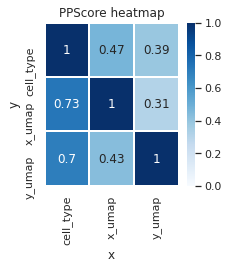

categoricals shape (581, 1)
one-hot encoded categoricals shape (581, 7)
new covs df shape (581, 10)
(9, 9)


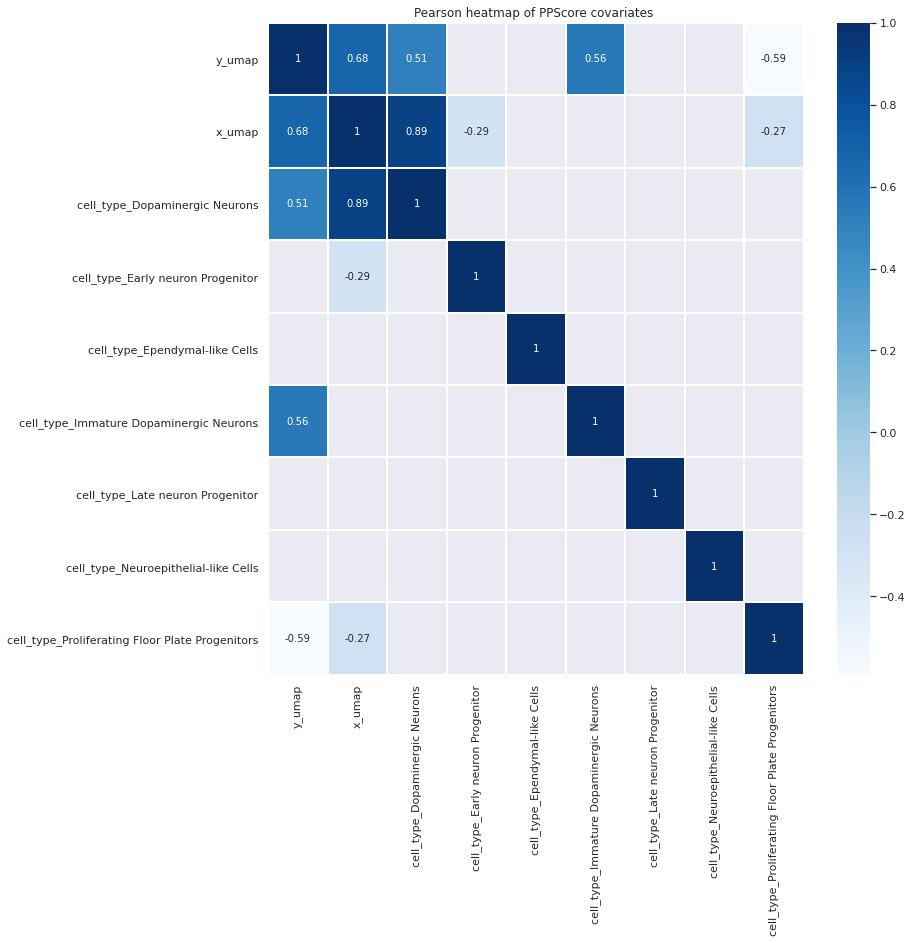

(6, 2)


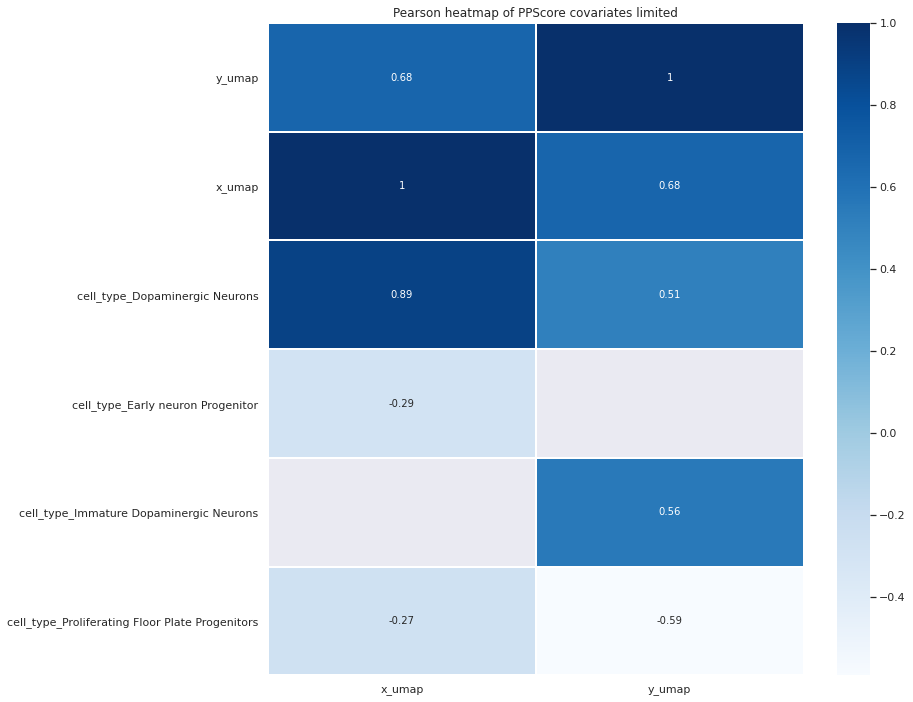

CPU times: user 11.4 s, sys: 199 ms, total: 11.6 s
Wall time: 5.32 s


In [41]:
%%time
# umap_df = generate_umap_covs_df(quants_var_df[no_change_variance_features], covs_df)
umap_df = generate_umap_covs_df(quants_var_df[variance_features], covs_df)
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

#### plot umap of with known covariates of interest

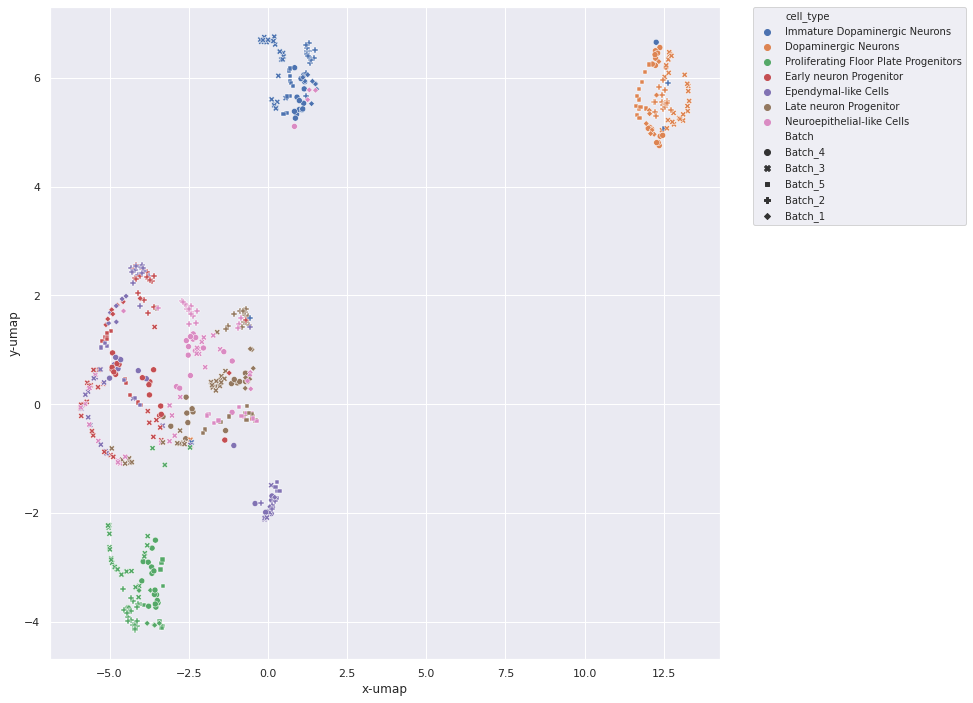

In [42]:
plot_umap_clusters(umap_df, hue_cov='cell_type', style_cov='Batch')

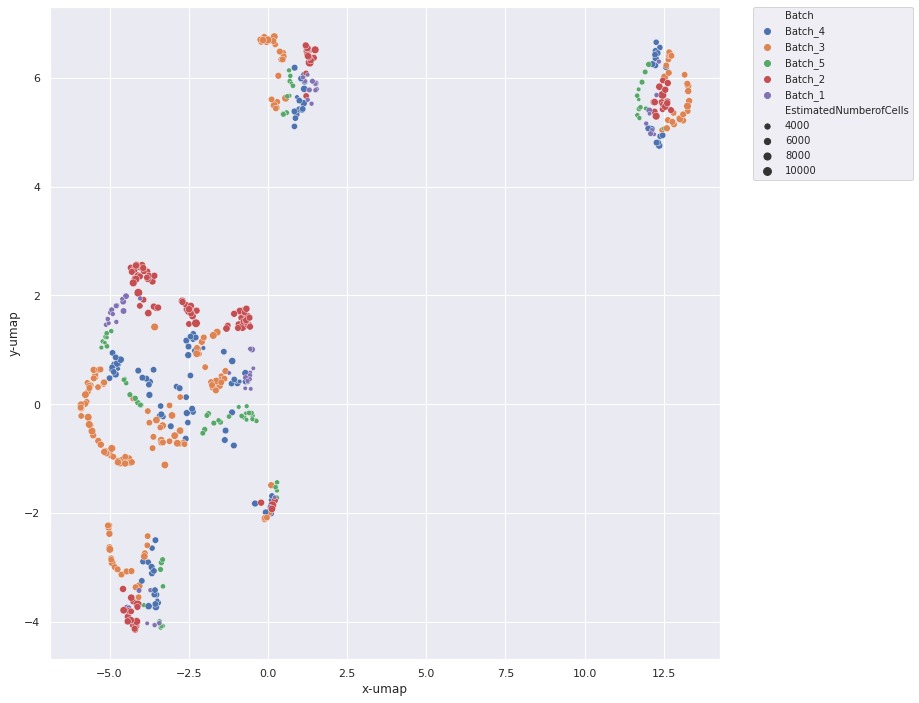

In [47]:
plot_umap_clusters(umap_df, hue_cov='Batch', size_cov='EstimatedNumberofCells')

#### keep created covars and save them

In [48]:
# standardize the covariates
umap_covs_df = scale_dataframe(umap_df[covs_target_list])
# now save the covariates
umap_covs_df.to_csv(umap_covs_file)

#### covariate adjust the scaled data by the covariates

In [49]:
# check to see in df's have same indices
if not traits_scaled_df.index.equals(umap_covs_df.index):
    print('indices are not equal re-index')
    umap_covs_df.reindex(traits_scaled_df.index)
    
traits_scaled_df.index.equals(umap_covs_df.index)    

True

In [50]:
%%time

residuals_df, cov_scores_df = covariate_residuals(traits_scaled_df, umap_covs_df)

#take a peek at the data
print(residuals_df.shape)
print(cov_scores_df.shape)

# print(cov_scores_df.head())

(581, 9611)
(9611, 1)
CPU times: user 13min 25s, sys: 15.1 s, total: 13min 40s
Wall time: 51.3 s


             score
count  9611.000000
mean      0.153678
std       0.119705
min       0.000000
25%       0.056000
50%       0.126000
75%       0.228000
max       0.641000


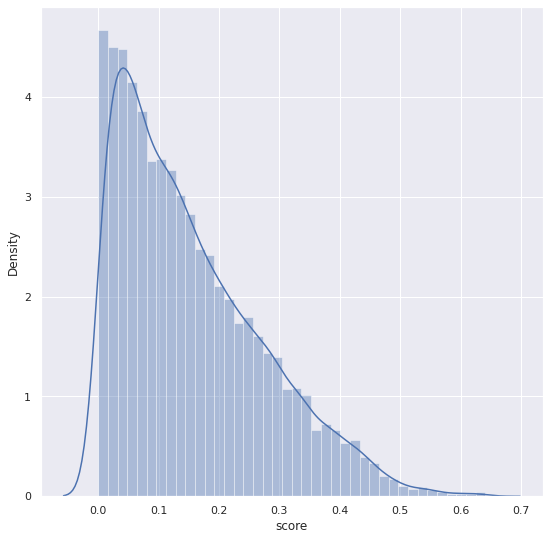

In [51]:
# get a summary of the covariates model scores
print(cov_scores_df.describe())
# look at the distribution of covariate model scores, 
# ie get a sense any feature driven by covariates
sns.set()
plt.figure(figsize=(9,9))
sns.distplot(cov_scores_df['score'])
plt.show()

#### save scaled and covariate adjusted data

In [52]:
%%time 

residuals_df.to_hdf(adj_quants_file, key='quants', mode='w')

CPU times: user 39.1 ms, sys: 60.5 ms, total: 99.6 ms
Wall time: 97.9 ms


#### take a look at the scaled and covariate adjusted data

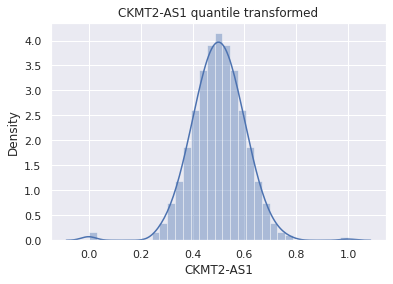

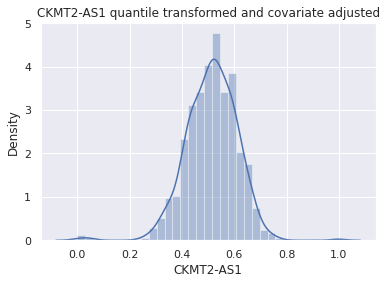

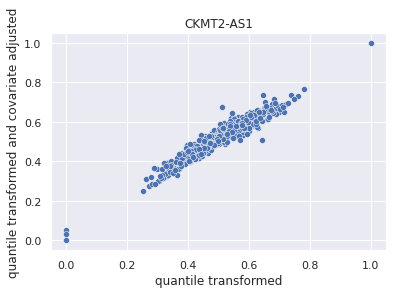

In [53]:
plot_trnsfrm_effect_example(traits_scaled_df, residuals_df)

           score
featureID       
PGM3       0.641


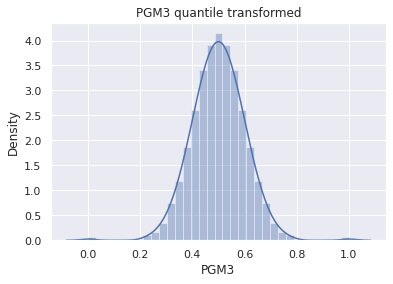

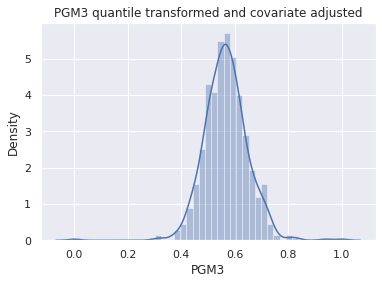

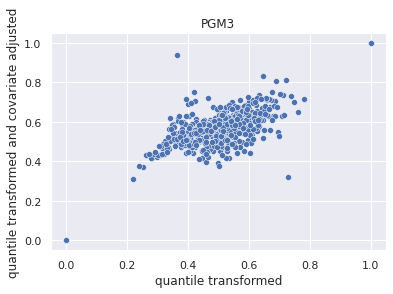

In [54]:
# find feature with largest score
large_adj_trait = cov_scores_df.loc[cov_scores_df['score'] == max(cov_scores_df['score'])]
print(large_adj_trait)
large_adj_traid_id = large_adj_trait.index.values[0]

# spot check same feature with largest adjustment effect
plot_trnsfrm_effect_example(traits_scaled_df, residuals_df, large_adj_traid_id)

#### what are the post scaled and covariate adjusted umap variables correlated with

The dimensions of the umap df and the traits are (581, 77)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,cell_type,x_umap,0.394027,regression,True,mean absolute error,2.23993,1.357337,DecisionTreeRegressor()
1,Differentiation_Start,x_umap,0.072195,regression,True,mean absolute error,2.23993,2.078218,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,cell_type,y_umap,0.433888,regression,True,mean absolute error,1.457980,0.825380,DecisionTreeRegressor()
1,x_umap,y_umap,0.185978,regression,True,mean absolute error,1.464952,1.192502,DecisionTreeRegressor()


found 4 covariates that may preditct target covariates
(12, 9)
(4, 4)


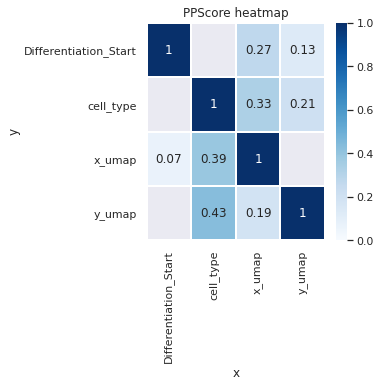

categoricals shape (581, 2)
one-hot encoded categoricals shape (581, 15)
new covs df shape (581, 19)
(17, 17)


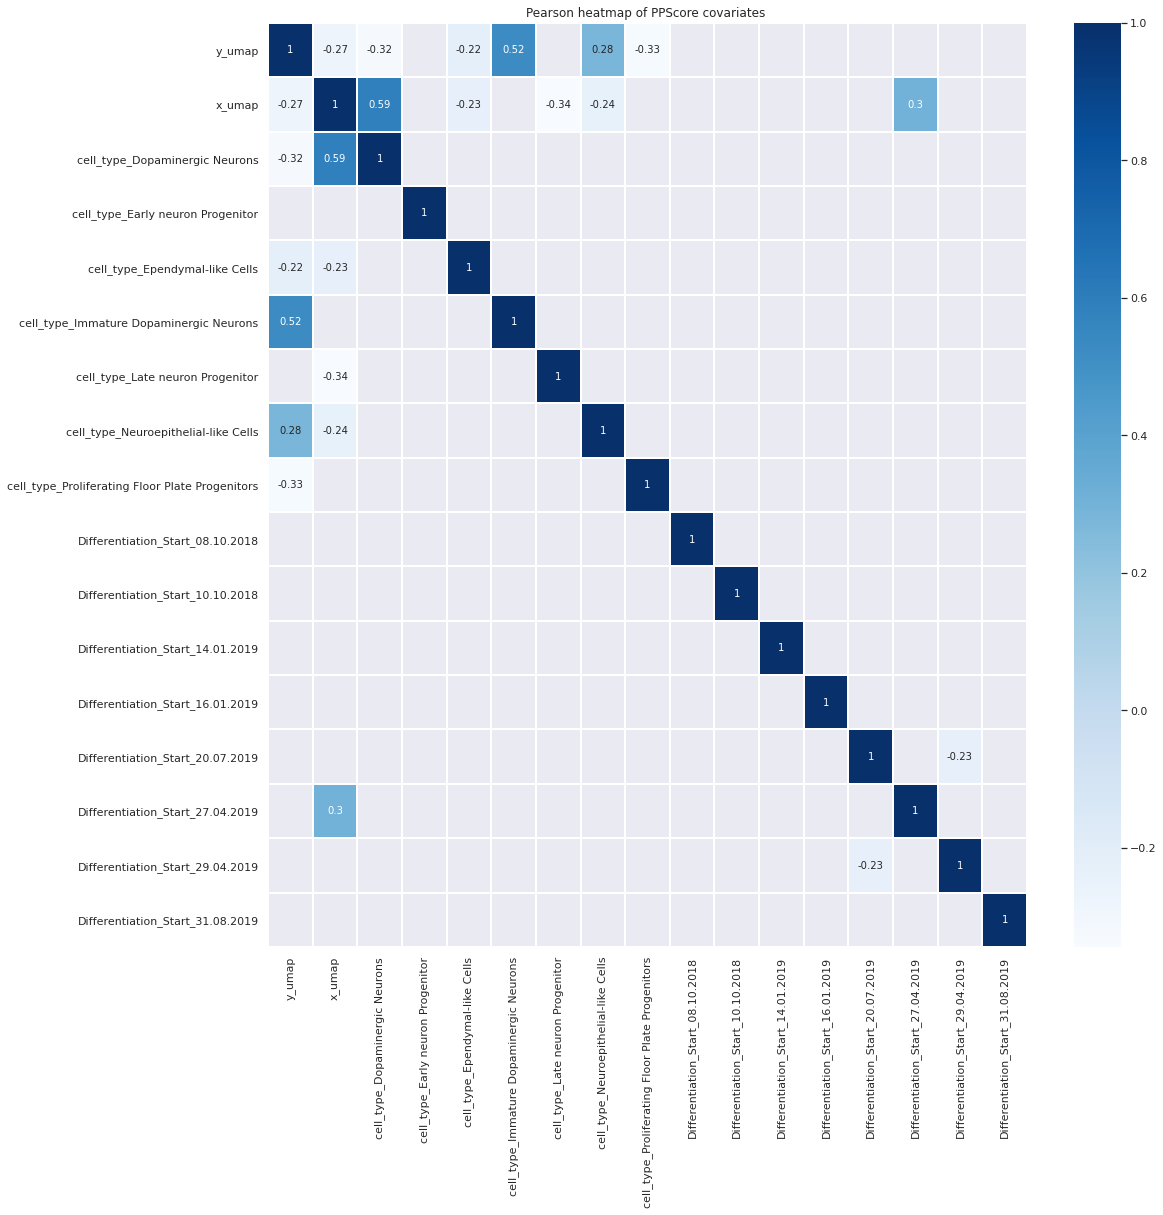

(9, 2)


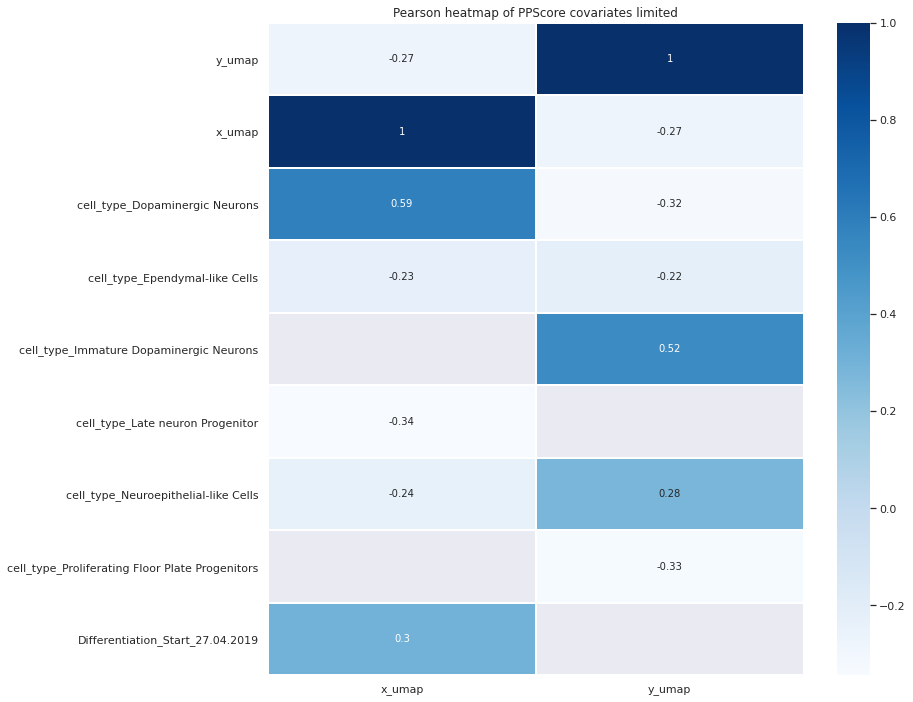

CPU times: user 11.5 s, sys: 251 ms, total: 11.8 s
Wall time: 5.52 s


In [55]:
%%time
umap_df = generate_umap_covs_df(residuals_df, covs_df)
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

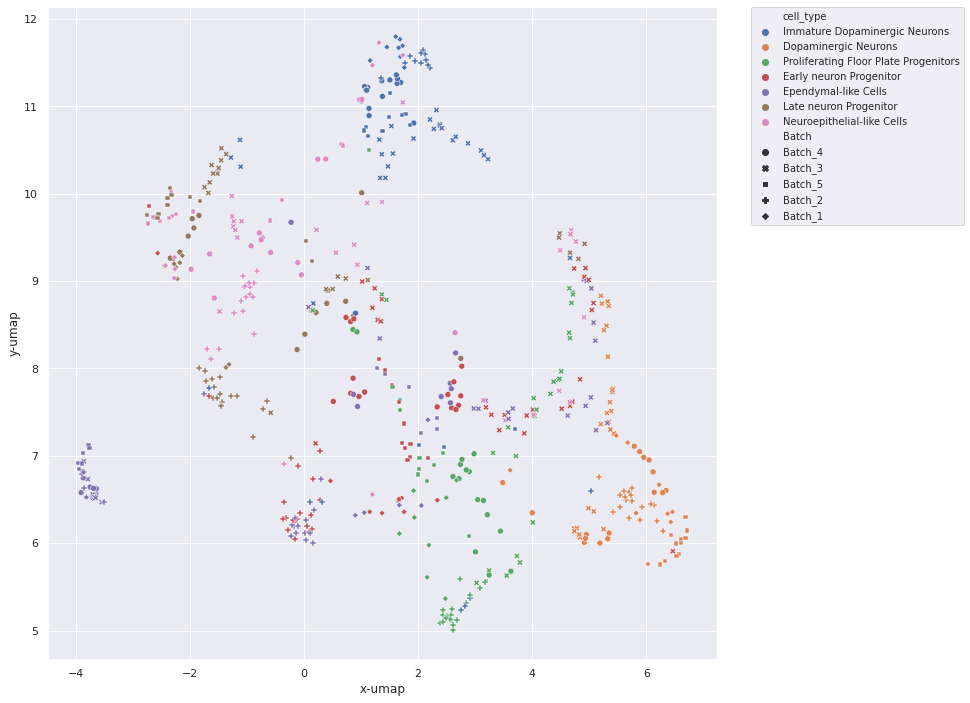

In [57]:
plot_umap_clusters(umap_df, hue_cov='cell_type', style_cov='Batch')